In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import os
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import ast
import ipywidgets as widgets
from sklearn.decomposition import PCA

In [2]:
ArtistD_df=pd.read_csv('./Artists In Production 1.csv')
Track_df=pd.read_csv('./Track In Production 1.csv')
genres_df=pd.read_csv('./Genre In Production.csv')

In [29]:
Track_df.rename(columns={'name': 'Track_name','popularity': 'Track_popularity',
                         'duration_ms': 'Track_duration_ms','danceability': 'Track_danceability',
                         'energy': 'Track_energy','loudness': 'Track_loudness','speechiness': 'Track_speechiness',
                         'acousticness': 'Track_acousticness','instrumentalness': 'Track_instrumentalness',
                         'liveness': 'Track_liveness','tempo': 'Track_tempo','valence': 'Track_valence','mode':'Track_mode'}, inplace=True)

In [110]:
Track_df['year'] = pd.DatetimeIndex(Track_df['release_date']).year
Track_df['release_date'] = pd.to_datetime(Track_df['release_date'])

In [271]:
Track_df.drop(Track_df[Track_df.Track_name.isnull()].index, inplace = True)
Track_df.drop(Track_df[Track_df['Track_name'] == 'Pause Track'].index, inplace = True)
Track_df.drop(Track_df[Track_df['Track_name'] == 'Pause Track - Live'].index, inplace = True)
Track_df_new = Track_df.drop(Track_df[Track_df.year < 1930].index, inplace = True)

In [ ]:
#Track_df.drop_duplicates(subset ="Track_df", keep = False, inplace = True)

In [32]:
ArtistD_df['genres'] = ArtistD_df.genres.apply(lambda x: ast.literal_eval(str(x)))
Track_df['artists']= Track_df.artists.apply(lambda x: ast.literal_eval(str(x)))

In [33]:
Track_df['solo'] = Track_df.apply(lambda row: row.artists[0], axis=1)

In [34]:
SOLO=ArtistD_df.copy(deep=True)
SOLO=SOLO.rename(columns={'artists': 'solo'})
SOLO.drop(['key','mode','count','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity'],axis=1, inplace = True)
Track_df=Track_df.merge(SOLO,how='left', on='solo')

In [35]:
Track_df.dropna(subset = ["genres"], inplace=True)

In [112]:
Track_df.drop(Track_df[Track_df['solo'] == 'Georgette Heyer'].index, inplace = True)
Track_df.drop(Track_df[Track_df['solo'] == 'Seweryn Goszczyński'].index, inplace = True)
Track_df.drop(Track_df[Track_df['solo'] == 'H.P. Lovecraft'].index, inplace = True)
Track_df.drop(Track_df[Track_df['solo'] == 'Zofia Dromlewiczowa'].index, inplace = True)

In [36]:
bin_labels_5 = ['Very Low', 'Low', 'Average', 'High', 'Very High']
Track_df['Popularity_perc'] = pd.qcut(Track_df['Track_popularity'], q=5 ,labels=bin_labels_5)
Track_df['Track_danceability_perc'] = pd.qcut(Track_df['Track_danceability'], q=5 ,labels=bin_labels_5)
Track_df['Track_energy_perc'] = pd.qcut(Track_df['Track_energy'], q=5 ,labels=bin_labels_5)
Track_df['Track_loudness_perc'] = pd.qcut(Track_df['Track_loudness'], q=5 ,labels=bin_labels_5)
Track_df['Track_speechiness_perc'] = pd.qcut(Track_df['Track_speechiness'], q=5 ,labels=bin_labels_5)
Track_df['Track_acousticness_perc'] = pd.qcut(Track_df['Track_acousticness'], q=5 ,labels=bin_labels_5)
Track_df['Track_instrumentalness_perc'] = pd.qcut(Track_df['Track_instrumentalness'], q=3 ,labels=['Low', 'Average', 'High'])
Track_df['Track_liveness_perc'] = pd.qcut(Track_df['Track_liveness'], q=5 ,labels=bin_labels_5)
Track_df['Track_valence_perc'] = pd.qcut(Track_df['Track_valence'], q=5 ,labels=bin_labels_5)
Track_df['Track_tempo_perc'] = pd.qcut(Track_df['Track_tempo'], q=5 ,labels=bin_labels_5)
Track_df['Track_duration_s'] = Track_df['Track_duration_ms'].apply(lambda x: x/60000)

ArtistD_df['popularity_perc'] = pd.qcut(ArtistD_df['popularity'], q=5 ,labels=bin_labels_5)
ArtistD_df['danceability_perc'] = pd.qcut(ArtistD_df['danceability'], q=5 ,labels=bin_labels_5)
ArtistD_df['energy_perc'] = pd.qcut(ArtistD_df['energy'], q=5 ,labels=bin_labels_5)
ArtistD_df['loudness_perc'] = pd.qcut(ArtistD_df['loudness'], q=5 ,labels=bin_labels_5)
ArtistD_df['speechiness_perc'] = pd.qcut(ArtistD_df['speechiness'], q=5 ,labels=bin_labels_5)
ArtistD_df['acousticness_perc'] = pd.qcut(ArtistD_df['acousticness'], q=5 ,labels=bin_labels_5)
ArtistD_df['instrumentalness_perc'] = pd.qcut(ArtistD_df['instrumentalness'], q=3 ,labels=['Low', 'Average', 'High'])
ArtistD_df['liveness_perc'] = pd.qcut(ArtistD_df['liveness'], q=5 ,labels=bin_labels_5)
ArtistD_df['valence_perc'] = pd.qcut(ArtistD_df['valence'], q=5 ,labels=bin_labels_5)
ArtistD_df['tempo_perc'] = pd.qcut(ArtistD_df['tempo'], q=5 ,labels=bin_labels_5)
ArtistD_df['duration_ms'] = ArtistD_df['duration_ms'].apply(lambda x: x/60000)

In [38]:
def GetKey(x,y):
    if y==0:
        return x
    return x+12

Track_df['FullKey'] = Track_df.apply(lambda x: GetKey(x.key, x.Track_mode), axis=1)

In [ ]:
# Track_df['Stressed'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([3,7,8,23]) else 0)
# Track_df['Anxious'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([3,7,20,10,8]) else 0)
# Track_df['Sad'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([0,2,6,7,8]) else 0)
# Track_df['Depressed'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([2,3,5,10,13,20]) else 0)
# Track_df['Happy'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([16,12,21,22,4]) else 0)
# Track_df['Calm'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([1,17,19,11,9]) else 0)
# Track_df['Contentment'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([16,18,19,22,11]) else 0)
# Track_df['Cheerful'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([12,14,16,21,22]) else 0)
# Track_df['Romantic'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([0,15,19,21,4]) else 0)
# Track_df['Lonely'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([2,17,5,10]) else 0)
# Track_df['Angry'] = Track_df.FullKey.apply(lambda x: 1 if x in np.array([6,7,20,10,23]) else 0)

# **Similar Songs to Clusters**

Assigne songs to clusters based on their characteristics.

In [4]:
Cluster_Songs=Track_df[['Track_tempo','Track_valence','Track_liveness','Track_instrumentalness','Track_acousticness',
                        'Track_popularity','explicit','Track_danceability','Track_energy','FullKey','Track_loudness',
                        'Track_speechiness']].copy(deep=True)

In [264]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=12,verbose=2))],verbose=True)
song_cluster_pipeline.fit(Cluster_Songs)
song_cluster_labels = song_cluster_pipeline.predict(Cluster_Songs)
Cluster_Songs['cluster_label'] = song_cluster_labels

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
Initialization complete
Iteration 0, inertia 2247968.136760633
Iteration 1, inertia 1724922.6364520402
Iteration 2, inertia 1678652.529343815
Iteration 3, inertia 1658985.1796863528
Iteration 4, inertia 1644854.7421974153
Iteration 5, inertia 1631880.3595416637
Iteration 6, inertia 1620791.8503564682
Iteration 7, inertia 1610831.0303055078
Iteration 8, inertia 1600059.5473825994
Iteration 9, inertia 1590294.4786089743
Iteration 10, inertia 1586096.3218109861
Iteration 11, inertia 1584239.0883372684
Iteration 12, inertia 1583246.310017222
Iteration 13, inertia 1582692.064847744
Iteration 14, inertia 1582350.2438273202
Iteration 15, inertia 1582134.9750441047
Iteration 16, inertia 1581993.551444497
Iteration 17, inertia 1581901.0825150225
Iteration 18, inertia 1581834.4587204757
Iteration 19, inertia 1581786.9083079863
Iteration 20, inertia 1581750.0609371779
Iteration 21, inertia 1581723.2194595914
Iteration 22, iner

Iteration 9, inertia 1611828.338668278
Iteration 10, inertia 1610745.4836002495
Iteration 11, inertia 1609803.2471539897
Iteration 12, inertia 1609025.6938001513
Iteration 13, inertia 1608381.7271721864
Iteration 14, inertia 1607832.3386980619
Iteration 15, inertia 1607377.7525205824
Iteration 16, inertia 1606972.1168782536
Iteration 17, inertia 1606628.1767965164
Iteration 18, inertia 1606294.164189778
Iteration 19, inertia 1605968.2338457624
Iteration 20, inertia 1605674.1522993888
Iteration 21, inertia 1605427.9512100834
Iteration 22, inertia 1605204.7235564224
Iteration 23, inertia 1605009.805819616
Iteration 24, inertia 1604854.802352855
Iteration 25, inertia 1604725.9160850295
Iteration 26, inertia 1604616.614936159
Iteration 27, inertia 1604518.3497171178
Iteration 28, inertia 1604429.2819844699
Iteration 29, inertia 1604344.7343504874
Iteration 30, inertia 1604266.2839381853
Iteration 31, inertia 1604199.7418112282
Iteration 32, inertia 1604141.501951052
Iteration 33, inertia 1

Iteration 20, inertia 1596394.471985817
Iteration 21, inertia 1596341.24094835
Iteration 22, inertia 1596288.2613861093
Iteration 23, inertia 1596243.135819258
Iteration 24, inertia 1596201.2127316275
Iteration 25, inertia 1596159.442348566
Iteration 26, inertia 1596118.9254996846
Iteration 27, inertia 1596079.002737385
Iteration 28, inertia 1596047.8137113517
Iteration 29, inertia 1596021.6653432916
Iteration 30, inertia 1595997.4933974992
Iteration 31, inertia 1595974.5913363684
Iteration 32, inertia 1595950.441111522
Iteration 33, inertia 1595926.2715396227
Iteration 34, inertia 1595902.4979160174
Iteration 35, inertia 1595881.3068501968
Iteration 36, inertia 1595861.509793296
Iteration 37, inertia 1595841.6222158745
Iteration 38, inertia 1595819.632927309
Iteration 39, inertia 1595801.3419637135
Iteration 40, inertia 1595784.630638466
Iteration 41, inertia 1595765.9906358758
Iteration 42, inertia 1595749.3625142027
Iteration 43, inertia 1595732.6383061733
Iteration 44, inertia 1595

In [ ]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(Cluster_Songs)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = Track_df['Track_name']
projection['cluster'] = Track_df['cluster_song_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

In [265]:
Track_df['cluster_song_label'] = song_cluster_labels

In [273]:
Track_df.groupby(['cluster_song_label']).size().reset_index(name='counts')

,cluster_song_label,counts
0,0,33133
1,1,30534
2,2,30214
3,3,10464
4,4,17089
5,5,47851
6,6,3783
7,7,35868
8,8,20211
9,9,32389


# **Assign Mood to Songs**

Assigne songs to clusters based on emotinal characteristics.

In [39]:
Cluster_Emotion=Track_df[['Track_valence','Track_danceability','Track_energy','Track_loudness']].copy(deep=True)

In [40]:
Emotion_cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=8,verbose=2))],verbose=True)
Emotion_cluster_pipeline.fit(Cluster_Emotion)
Emotion_cluster_labels = Emotion_cluster_pipeline.predict(Cluster_Emotion)
Cluster_Emotion['cluster_label'] = Emotion_cluster_labels

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
Initialization complete
Iteration 0, inertia 423785.13403002353
Iteration 1, inertia 395735.7156332901
Iteration 2, inertia 383823.7306061936
Iteration 3, inertia 374686.28063855175
Iteration 4, inertia 369224.3572256146
Iteration 5, inertia 364452.10507901816
Iteration 6, inertia 359241.6673402943
Iteration 7, inertia 352988.397977405
Iteration 8, inertia 347759.2454368901
Iteration 9, inertia 344494.7955331747
Iteration 10, inertia 342619.81825219025
Iteration 11, inertia 341486.3017856189
Iteration 12, inertia 340777.65535176324
Iteration 13, inertia 340303.2292830437
Iteration 14, inertia 340008.772290371
Iteration 15, inertia 339816.1452572535
Iteration 16, inertia 339683.49804369395
Iteration 17, inertia 339593.4013699972
Iteration 18, inertia 339534.54277604085
Iteration 19, inertia 339490.71148070326
Iteration 20, inertia 339456.9502768427
Iteration 21, inertia 339432.29939755047
Iteration 22, inertia 339411

Iteration 8, inertia 332725.7116626962
Iteration 9, inertia 332273.0414748011
Iteration 10, inertia 331926.93098999554
Iteration 11, inertia 331649.8869718479
Iteration 12, inertia 331421.08222404716
Iteration 13, inertia 331227.1846151433
Iteration 14, inertia 331062.47161250707
Iteration 15, inertia 330909.87625492783
Iteration 16, inertia 330774.9967324075
Iteration 17, inertia 330647.2072148428
Iteration 18, inertia 330535.8875794408
Iteration 19, inertia 330436.15716626967
Iteration 20, inertia 330345.7197240084
Iteration 21, inertia 330257.99850064254
Iteration 22, inertia 330176.3354908145
Iteration 23, inertia 330096.1322256353
Iteration 24, inertia 330025.14790930145
Iteration 25, inertia 329959.19288428343
Iteration 26, inertia 329901.5182366427
Iteration 27, inertia 329846.0823161713
Iteration 28, inertia 329794.2248867376
Iteration 29, inertia 329745.1191028304
Iteration 30, inertia 329696.3944643696
Iteration 31, inertia 329651.3986165737
Iteration 32, inertia 329607.16799

Iteration 27, inertia 326754.2563043986
Iteration 28, inertia 326678.28880932863
Iteration 29, inertia 326613.11872798845
Iteration 30, inertia 326562.08822338266
Iteration 31, inertia 326521.5881142114
Iteration 32, inertia 326486.97806294326
Iteration 33, inertia 326460.49315735704
Iteration 34, inertia 326439.776319737
Iteration 35, inertia 326420.6901837417
Iteration 36, inertia 326406.00196124485
Iteration 37, inertia 326393.3832902436
Iteration 38, inertia 326382.5928858087
Iteration 39, inertia 326374.0071391247
Converged at iteration 39: center shift 9.00629371882956e-05 within tolerance 0.00010000000000000613.
Initialization complete
Iteration 0, inertia 459399.3006936355
Iteration 1, inertia 395309.1935162938
Iteration 2, inertia 375170.4579535207
Iteration 3, inertia 363224.28041788616
Iteration 4, inertia 355113.41787515907
Iteration 5, inertia 348873.7742268008
Iteration 6, inertia 343842.4287985766
Iteration 7, inertia 340341.4315915068
Iteration 8, inertia 337927.6638386

In [41]:
Track_df['cluster_mood_label'] = Emotion_cluster_labels

In [42]:
Track_df.groupby('cluster_mood_label').Track_valence_perc.value_counts()

cluster_mood_label  Track_valence_perc
0                   Low                   17454
                    Average                9300
                    Very Low               8738
                    High                     24
1                   Very Low              18358
                    Low                    3265
                    Average                 628
                    High                    109
                    Very High                26
2                   Very High             27407
                    High                  20178
                    Average                8195
                    Low                     466
                    Very Low                  1
3                   Very High             21818
                    High                  14133
                    Average                3702
                    Low                      30
4                   Very Low              23827
                    Low                   15546
 

In [43]:
Track_df.groupby('cluster_mood_label').Track_danceability_perc.value_counts()

cluster_mood_label  Track_danceability_perc
0                   High                       12994
                    Average                    12041
                    Very High                   7231
                    Low                         3250
1                   Very Low                   16693
                    Low                         4545
                    Average                      998
                    High                         146
                    Very High                      4
2                   Very High                  24361
                    High                       19872
                    Average                    10072
                    Low                         1898
                    Very Low                      44
3                   Very High                  24441
                    High                       14164
                    Average                     1078
4                   Very Low                   25777
  

In [44]:
Track_df.groupby('cluster_mood_label').Track_energy_perc.value_counts()

cluster_mood_label  Track_energy_perc
0                   Average              15512
                    High                 10606
                    Low                   7453
                    Very High             1497
                    Very Low               448
1                   Very Low             21632
                    Low                    634
                    Average                 54
                    High                    34
                    Very High               32
2                   Very High            32922
                    High                 21967
                    Average               1357
                    Low                      1
3                   Average              18028
                    Low                  11541
                    High                  7783
                    Very Low              2221
                    Very High              110
4                   Low                  20169
                    Ve

In [46]:
Track_df.groupby('cluster_mood_label').Track_loudness_perc.value_counts()

cluster_mood_label  Track_loudness_perc
0                   High                   13554
                    Average                10757
                    Very High               7055
                    Low                     4009
                    Very Low                 141
1                   Very Low               22381
                    Low                        5
2                   Very High              30641
                    High                   18643
                    Average                 6210
                    Low                      750
                    Very Low                   3
3                   Low                    14795
                    Average                13815
                    High                    6163
                    Very Low                3905
                    Very High               1005
4                   Low                    18004
                    Average                10875
                    Very Low 

In [47]:
Track_df.groupby(['cluster_mood_label']).size().reset_index(name='counts')

,cluster_mood_label,counts
0,0,35516
1,1,22386
2,2,56247
3,3,39683
4,4,42087
5,5,34215
6,6,38220
7,7,37214


In [115]:
def s(x):
    z=[]
    if x==0:
        z.append('Angry')
        z.append('Lonely')
        z.append('Romantic')
    if x==1:
        z.append('Stressed')
        z.append('Sad')
    if x==2:
        z.append('Happy')
        z.append('Cheerful')
    if x==3:
        z.append('Contentment')
        z.append('Happy')
        z.append('Romantic')  
    if x==4:
        z.append('Stressed')
        z.append('Sad')
        z.append('Lonely')
    if x==5:
        z.append('Angry')
        z.append('Contentment')
    if x==6:
        z.append('Contentment')
        z.append('Calm')
        z.append('Romantic') 
    if x==7:
        z.append('Stressed')
        z.append('Sad')
        z.append('Calm')
        z.append('Lonely')
    z = list(dict.fromkeys(z))
    return z

In [116]:
Track_df['mood']=Track_df.cluster_mood_label.apply(lambda x: s(x))

In [254]:
# Track_df[['Track_name','mood']].loc[Track_df['solo']=='Adele'].head(50)

In [13]:
Track_df.to_csv('C:/Users/User/OneDrive/Desktop/Untitled Folder/Track In Production 1.csv')

# **Assign Activity to Songs**

Assigne songs to clusters based on activity characteristics.

In [8]:
from yellowbrick.target import FeatureCorrelation

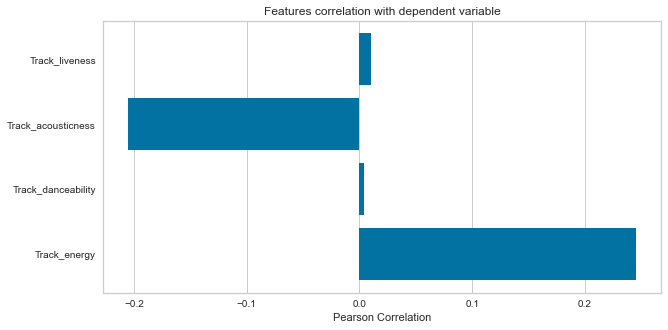

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [10]:
feature_names = ['Track_energy', 'Track_danceability','Track_acousticness','Track_liveness']
X, y = Track_df[feature_names], Track_df['Track_tempo']
features = np.array(feature_names)
visualizer = FeatureCorrelation(labels=features)
plt.rcParams['figure.figsize']=(10,5)
visualizer.fit(X, y)
visualizer.show()  

In [203]:
Cluster_Activity=Track_df[['Track_danceability','Track_tempo','Track_energy','Track_acousticness']].copy(deep=True)

In [204]:
Activity_cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=6,verbose=2))],verbose=True)
Activity_cluster_pipeline.fit(Cluster_Activity)
Activity_cluster_labels = Activity_cluster_pipeline.predict(Cluster_Activity)
Cluster_Activity['cluster_label'] = Activity_cluster_labels

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
Initialization complete
Iteration 0, inertia 571507.0671717788
Iteration 1, inertia 440046.4675252253
Iteration 2, inertia 422902.5684900563
Iteration 3, inertia 414313.8240945803
Iteration 4, inertia 410361.9817446881
Iteration 5, inertia 408609.32687457907
Iteration 6, inertia 407801.1745572857
Iteration 7, inertia 407427.29366041074
Iteration 8, inertia 407244.48930712807
Iteration 9, inertia 407155.957797185
Iteration 10, inertia 407106.03028731694
Iteration 11, inertia 407077.4409731535
Iteration 12, inertia 407061.4841150216
Iteration 13, inertia 407053.26207512734
Converged at iteration 13: center shift 5.8813526828183896e-05 within tolerance 9.999999999999906e-05.
Initialization complete
Iteration 0, inertia 626478.2949849804
Iteration 1, inertia 497847.3637796394
Iteration 2, inertia 469205.03017249703
Iteration 3, inertia 447222.93904296646
Iteration 4, inertia 433157.9037461133
Iteration 5, inertia 426342

Iteration 7, inertia 408770.9406401819
Iteration 8, inertia 407985.1510053244
Iteration 9, inertia 407559.3571001545
Iteration 10, inertia 407329.9816939327
Iteration 11, inertia 407193.4491057732
Iteration 12, inertia 407122.1839660072
Iteration 13, inertia 407085.03136846767
Iteration 14, inertia 407066.5557855216
Iteration 15, inertia 407057.2369133369
Converged at iteration 15: center shift 6.155610912256807e-05 within tolerance 9.999999999999906e-05.
Initialization complete
Iteration 0, inertia 599528.4285618031
Iteration 1, inertia 458951.89737219654
Iteration 2, inertia 432889.95549715863
Iteration 3, inertia 424052.3222787582
Iteration 4, inertia 419188.55844697054
Iteration 5, inertia 416005.7725424659
Iteration 6, inertia 413849.28576239053
Iteration 7, inertia 412444.15369010484
Iteration 8, inertia 411463.45743938023
Iteration 9, inertia 410760.048764871
Iteration 10, inertia 410222.54966392403
Iteration 11, inertia 409774.3447662405
Iteration 12, inertia 409341.6419768845


In [183]:
Track_df['cluster_activity_label'] = Activity_cluster_labels

In [205]:
Track_df.groupby('cluster_activity_label').Track_danceability_perc.value_counts()

cluster_activity_label  Track_danceability_perc
0                       Very High                  37350
                        High                       23803
                        Average                    12502
                        Low                         4185
                        Very Low                      88
1                       Very Low                   21284
                        Low                        18280
                        Average                     5917
                        High                         130
2                       Very Low                   17290
                        Low                         9656
                        Average                     6982
                        High                        4834
                        Very High                   2494
3                       Low                        11647
                        Very Low                    9914
                        Average         

In [206]:
Track_df.groupby('cluster_activity_label').Track_tempo_perc.value_counts()

cluster_activity_label  Track_tempo_perc
0                       Low                 23598
                        Average             22908
                        High                17506
                        Very Low            11260
                        Very High            2656
1                       Very Low            27060
                        Low                 12747
                        Average              5699
                        High                  105
2                       Very Low            13382
                        Low                  7743
                        High                 7597
                        Average              7271
                        Very High            5263
3                       Very High           21742
                        High                 9004
                        Average               372
4                       Average             19221
                        Low                 14905
         

In [207]:
Track_df.groupby('cluster_activity_label').Track_energy_perc.value_counts()

cluster_activity_label  Track_energy_perc
0                       High                 27241
                        Very High            27095
                        Average              16783
                        Low                   6158
                        Very Low               651
1                       Very Low             17224
                        Low                  13733
                        Average               8209
                        High                  4342
                        Very High             2103
2                       Very Low             20214
                        Low                   9164
                        Average               4895
                        Very High             3742
                        High                  3241
3                       Low                   9748
                        Very Low              7847
                        Average               7540
                        High            

In [208]:
Track_df.groupby('cluster_activity_label').Track_acousticness_perc.value_counts()

cluster_activity_label  Track_acousticness_perc
0                       Low                        37980
                        Very Low                   30810
                        Average                     9138
1                       High                       15796
                        Very High                  15321
                        Average                    10342
                        Low                         2991
                        Very Low                    1161
2                       Very High                  23069
                        High                        8503
                        Very Low                    3710
                        Average                     3637
                        Low                         2337
3                       High                       12974
                        Average                    10669
                        Very High                   7455
                        Low             

In [209]:
Track_df.groupby(['cluster_activity_label']).size().reset_index(name='counts')

,cluster_activity_label,counts
0,0,77928
1,1,45611
2,2,41256
3,3,31118
4,4,56543
5,5,47315


In [1]:
def a(x):
    z=[]
    if x==0:
        z.append('Partying')
        z.append('Playing Games')
        z.append('Playing Sport')
    if x==1:
        z.append('Working')
        z.append('Walking')
        z.append('Studying')
    if x==2:
        z.append('Driving')
        z.append('Studying')
    if x==3:
        z.append('Working')
        z.append('Walking')  
    if x==4:
        z.append('Partying')
        z.append('Driving')
    if x==5:
        z.append('Playing Sport')
        z.append('Playing Games')
    
    z = list(dict.fromkeys(z))
    return z

In [224]:
Track_df['activity']=Track_df.cluster_activity_label.apply(lambda x: a(x))

In [246]:
Track_df.loc[(Track_df['genres'].apply(lambda x: 'water' in x))|(Track_df['genres'].apply(lambda x: 'sleep' in x))
            |(Track_df['genres'].apply(lambda x: 'environmental' in x))|(Track_df['genres'].apply(lambda x: 'meditation' in x))
            |(Track_df['genres'].apply(lambda x: 'white noise' in x))|(Track_df['genres'].apply(lambda x: 'atmosphere' in x))
            |(Track_df['genres'].apply(lambda x: 'calming instrumental' in x)), "activity"] = 'Sleeping'

# **Similar Artists to Clusters**

Assigne Artists to clusters based on their characteristics.

In [274]:
Cluster_Artists=ArtistD_df[['tempo','valence','liveness','instrumentalness','acousticness','popularity','danceability','energy','loudness','speechiness']].copy(deep=True)

In [275]:
Artists_cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=4,verbose=2))],verbose=True)
Artists_cluster_pipeline.fit(Cluster_Artists)
Artists_cluster_labels = Artists_cluster_pipeline.predict(Cluster_Artists)
Cluster_Artists['cluster_label'] = Artists_cluster_labels

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Initialization complete
Iteration 0, inertia 272516.84496858733
Iteration 1, inertia 187106.79808937694
Iteration 2, inertia 184056.70924091013
Iteration 3, inertia 183037.79821448398
Iteration 4, inertia 182390.40343576059
Iteration 5, inertia 181936.04826781602
Iteration 6, inertia 181562.10142323718
Iteration 7, inertia 181238.12484736688
Iteration 8, inertia 180922.41056402127
Iteration 9, inertia 180530.28889219437
Iteration 10, inertia 180035.60064083425
Iteration 11, inertia 179297.12345324966
Iteration 12, inertia 178226.0482077069
Iteration 13, inertia 176803.6130556693
Iteration 14, inertia 175363.16818541515
Iteration 15, inertia 174270.8994517866
Iteration 16, inertia 173560.3688573055
Iteration 17, inertia 173174.76440201738
Iteration 18, inertia 172962.22410763844
Iteration 19, inertia 172845.60300939647
Iteration 20, inertia 172767.38435809885
Iteration 21, inertia 172727.53479984787
Iteration 22, ine

Iteration 1, inertia 182788.26254972673
Iteration 2, inertia 180364.01259653404
Iteration 3, inertia 179690.00328015504
Iteration 4, inertia 179420.69441882256
Iteration 5, inertia 179281.2848940763
Iteration 6, inertia 179207.1899187226
Iteration 7, inertia 179162.47815108698
Iteration 8, inertia 179128.76559127448
Iteration 9, inertia 179102.7969257148
Iteration 10, inertia 179084.9394043772
Iteration 11, inertia 179065.25299700873
Iteration 12, inertia 179041.46497827923
Iteration 13, inertia 179014.73207238907
Iteration 14, inertia 178989.8347726177
Iteration 15, inertia 178970.17198661776
Iteration 16, inertia 178944.5887628413
Iteration 17, inertia 178926.58589667192
Iteration 18, inertia 178902.8142209448
Iteration 19, inertia 178857.23901682487
Iteration 20, inertia 178786.0290868067
Iteration 21, inertia 178664.86152051753
Iteration 22, inertia 178405.28007923582
Iteration 23, inertia 177892.79945849272
Iteration 24, inertia 177083.46250636724
Iteration 25, inertia 176085.0313

In [277]:
ArtistD_df['cluster_artists_label'] =Artists_cluster_labels

In [281]:
ArtistD_df.groupby(['cluster_artists_label']).size().reset_index(name='counts')

,cluster_artists_label,counts
0,0,14402
1,1,1657
2,2,4439
3,3,8182


In [ ]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(Cluster_Artists)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = ArtistD_df['artists']
projection['cluster'] = ArtistD_df['cluster_artists_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()